# Configs and Imports

In [1]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import gc

warnings.filterwarnings('ignore')

In [2]:
TARGET = 'Response'
N_FOLDS = 5
SEED = 90
ES_ROUNDS = 150
ES_LOG_STEPS = 500

TRAIN_PATH = '/kaggle/input/playground-series-s4e7/train.csv'
TEST_PATH = '/kaggle/input/playground-series-s4e7/test.csv'
ORIGINAL_PATH = '/kaggle/input/health-insurance-cross-sell-prediction-data/train.csv'

# Loading and Processing The Datasets

In [3]:
class DataLoader:
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path

    @staticmethod
    def encode_categorical_features(dataframe):  
        print('--- Encoding categorical features')
        
        gender_mapping = {'Male': 0, 'Female': 1}
        vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
        vehicle_damage_mapping = {'No': 0, 'Yes': 1}
        
        dataframe['Gender'] = dataframe['Gender'].map(gender_mapping)
        dataframe['Vehicle_Age'] = dataframe['Vehicle_Age'].map(vehicle_age_mapping)
        dataframe['Vehicle_Damage'] = dataframe['Vehicle_Damage'].map(vehicle_damage_mapping)
        
        return dataframe
    
    @staticmethod
    def convert_data_types(dataframe):  
        print('--- Converting data types')
        
        dataframe['Region_Code'] = dataframe['Region_Code'].astype(int) 
        dataframe['Annual_Premium'] = dataframe['Annual_Premium'].astype(int) 
        dataframe['Policy_Sales_Channel'] = dataframe['Policy_Sales_Channel'].astype(int) 
        
        return dataframe
    
    @staticmethod
    def add_features(dataframe):  
        print("--- Adding new features")
        # Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
        # Beware of data leakage
        dataframe['Previously_Insured_Annual_Premium'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Annual_Premium'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Age'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Age'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Damage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Damage'].astype(str))[0]
        dataframe['Previously_Insured_Vintage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vintage'].astype(str))[0]
        
        return dataframe
    
    @staticmethod
    def reduce_mem_usage(dataframe):
        # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516103#2899151
        
        print('--- Reducing memory usage')
        initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype

            if col_type.name in ['category', 'object']:
                raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

        final_mem_usage = dataframe.memory_usage().sum() / 1024**2
        print('------ Memory usage before: {:.2f} MB'.format(initial_mem_usage))
        print('------ Memory usage after: {:.2f} MB'.format(final_mem_usage))
        print('------ Decreased memory usage by {:.1f}%'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

        return dataframe

    @staticmethod
    def reflip_flipped_targets(train_df):
        # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/520253
        original_df = pd.read_csv(ORIGINAL_PATH, index_col="id")

        train_df["is_original"] = False
        original_df["is_original"] = True
        combined = pd.concat([train_df, original_df], axis=0)

        duplicates = combined.duplicated(subset=combined.columns[:-2], keep=False)
        duplicates = duplicates[duplicates].index

        combined.loc[duplicates, TARGET] = 1 - combined.loc[duplicates, TARGET]
        train_df = combined[~combined["is_original"]].drop(columns="is_original")

        del original_df, combined, duplicates
        gc.collect()

        return train_df

    def load(self):
        print(f'Loading data')
        
        train = pd.read_csv(self.train_path, index_col='id')
        test = pd.read_csv(self.test_path, index_col='id')
        
        train = self.reflip_flipped_targets(train)
        
        train['is_train'] = 1
        test['is_train'] = 0
        dataframe = pd.concat([train, test])
        del train, test
        gc.collect()
        
        dataframe = self.encode_categorical_features(dataframe)
        dataframe = self.convert_data_types(dataframe)
        dataframe = self.add_features(dataframe)
        dataframe = self.reduce_mem_usage(dataframe)
        
        train = dataframe[dataframe['is_train'] == 1].drop(columns=['is_train'])
        test = dataframe[dataframe['is_train'] == 0].drop(columns=['is_train', TARGET])
        
        del dataframe
        gc.collect()
        
        train[TARGET] = train[TARGET].astype(np.int8)
        
        return train, test

In [4]:
train, test = DataLoader(TRAIN_PATH, TEST_PATH).load()

X = train.drop(columns=TARGET)
y = train[TARGET]

Loading data
--- Encoding categorical features
--- Converting data types
--- Adding new features
--- Reducing memory usage
------ Memory usage before: 2486.95 MB
------ Memory usage after: 621.74 MB
------ Decreased memory usage by 75.0%


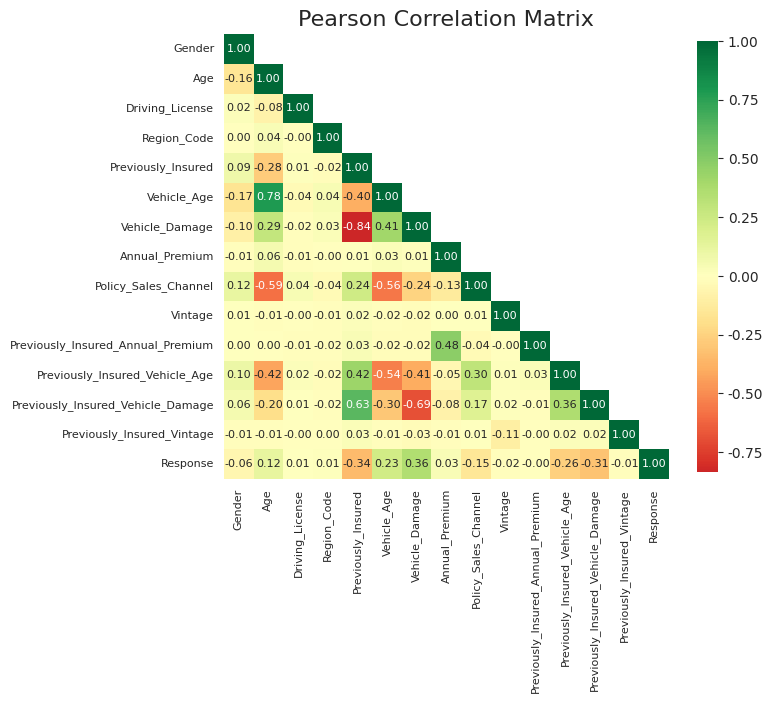

10

In [5]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 8))

cols = list(X.columns) + [TARGET]
temp_train = train[cols]

corr_train = temp_train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='RdYlGn',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax 
)

ax.set_title('Pearson Correlation Matrix', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

del temp_train, corr_train, mask_train
gc.collect()

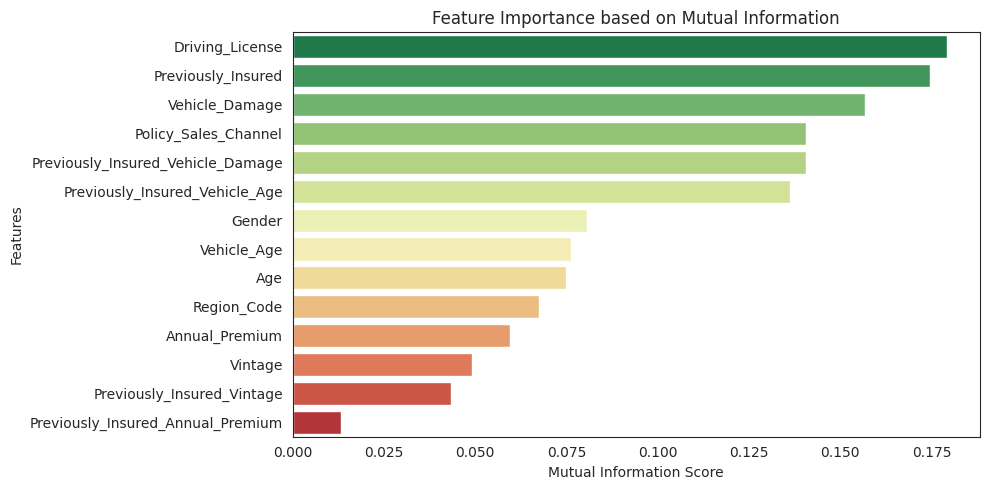

5650

In [6]:
train_mi = train.copy()
train_mi = train_mi.sample(1000_000)
X_mi = train_mi.drop(columns=TARGET)
y_mi = train_mi[TARGET]

mutual_info = mutual_info_classif(X_mi, y_mi, random_state=SEED)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])

plt.figure(figsize=(10, 5))
sns.barplot(x=mutual_info['Mutual Information'], y=mutual_info.index, palette='RdYlGn_r')
plt.title('Feature Importance based on Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

del train_mi, X_mi, y_mi
gc.collect()

# Training

In [7]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []
        feature_importances = np.zeros(X.shape[1])
        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        test_preds = []
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            train_pool = Pool(X_train, y_train, cat_features=X_train.columns.values)
            val_pool = Pool(X_val, y_val, cat_features=X_val.columns.values)
            test_pool = Pool(X_test, cat_features=X_test.columns.values)
            
            model = clone(self.model)
            model.fit(
                X=train_pool, 
                eval_set=val_pool, 
                verbose=ES_LOG_STEPS, 
                early_stopping_rounds=ES_ROUNDS,
                use_best_model=True
            )
            
            feature_importances += model.feature_importances_ / self.n_folds
            
            y_pred_probs = model.predict_proba(val_pool)
            oof_pred_probs[val_idx] = y_pred_probs            
            
            temp_test_pred_probs = model.predict_proba(test_pool)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            test_preds.append(temp_test_pred_probs[:, 1])
            
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs, temp_test_pred_probs, train_pool, val_pool, test_pool
            gc.collect()
            
            print(f'\n--- Fold {fold_idx + 1} - AUC: {score:.5f}\n\n')
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_preds, np.mean(scores))
        
        gc.collect()
        
        print(f'------ Average AUC:      {np.mean(scores):.5f} ± {np.std(scores):.5f}\n\n')

        return oof_pred_probs, scores, feature_importances
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{model_name}_{name}_pred_probs_{cv_score:.5f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_preds, score):
        sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
        
        sub['id'] = sub['id']
        sub[TARGET] = np.mean(test_preds, axis=0)
        
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub.to_csv(f'sub_{name}_{score:.5f}.csv', index=False)

In [8]:
params = {
    'iterations': 5000,
    'eval_metric': 'AUC',
    'task_type': 'GPU',
    'random_state': SEED
}

model = CatBoostClassifier(**params)
trainer = Trainer(model)
oof_pred_probs, scores, feature_importances = trainer.fit_predict(X, y, test)

Training CatBoostClassifier

Learning rate set to 0.016835


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8643242	best: 0.8643242 (0)	total: 10.3s	remaining: 14h 22m 18s
500:	test: 0.8891478	best: 0.8891478 (500)	total: 7m 29s	remaining: 1h 7m 15s
1000:	test: 0.8907596	best: 0.8907596 (1000)	total: 14m 44s	remaining: 58m 54s
1500:	test: 0.8913847	best: 0.8913847 (1500)	total: 21m 54s	remaining: 51m 3s
2000:	test: 0.8917193	best: 0.8917193 (2000)	total: 28m 58s	remaining: 43m 25s
2500:	test: 0.8919408	best: 0.8919408 (2500)	total: 36m 2s	remaining: 36m
3000:	test: 0.8921170	best: 0.8921170 (3000)	total: 43m 7s	remaining: 28m 43s
3500:	test: 0.8922475	best: 0.8922475 (3500)	total: 50m 11s	remaining: 21m 29s
4000:	test: 0.8923451	best: 0.8923452 (3998)	total: 57m 13s	remaining: 14m 17s
4500:	test: 0.8924255	best: 0.8924255 (4500)	total: 1h 4m 16s	remaining: 7m 7s
4999:	test: 0.8924987	best: 0.8924987 (4999)	total: 1h 11m 20s	remaining: 0us
bestTest = 0.8924987316
bestIteration = 4999

--- Fold 1 - AUC: 0.89250


Learning rate set to 0.016835


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8642976	best: 0.8642976 (0)	total: 890ms	remaining: 1h 14m 9s
500:	test: 0.8892270	best: 0.8892270 (500)	total: 7m 19s	remaining: 1h 5m 49s
1000:	test: 0.8907902	best: 0.8907902 (1000)	total: 14m 36s	remaining: 58m 20s
1500:	test: 0.8914145	best: 0.8914145 (1500)	total: 21m 42s	remaining: 50m 35s
2000:	test: 0.8917748	best: 0.8917748 (2000)	total: 28m 51s	remaining: 43m 14s
2500:	test: 0.8919953	best: 0.8919953 (2500)	total: 35m 59s	remaining: 35m 57s
3000:	test: 0.8921660	best: 0.8921660 (3000)	total: 43m 3s	remaining: 28m 40s
3500:	test: 0.8922890	best: 0.8922890 (3500)	total: 50m 6s	remaining: 21m 27s
4000:	test: 0.8923936	best: 0.8923936 (4000)	total: 57m 10s	remaining: 14m 16s
4500:	test: 0.8924723	best: 0.8924723 (4500)	total: 1h 4m 11s	remaining: 7m 7s
4999:	test: 0.8925391	best: 0.8925391 (4999)	total: 1h 11m 12s	remaining: 0us
bestTest = 0.892539084
bestIteration = 4999

--- Fold 2 - AUC: 0.89254


Learning rate set to 0.016835


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8639303	best: 0.8639303 (0)	total: 890ms	remaining: 1h 14m 10s
500:	test: 0.8889926	best: 0.8889926 (500)	total: 7m 21s	remaining: 1h 6m 2s
1000:	test: 0.8905605	best: 0.8905605 (1000)	total: 14m 35s	remaining: 58m 16s
1500:	test: 0.8911762	best: 0.8911762 (1500)	total: 21m 42s	remaining: 50m 35s
2000:	test: 0.8915181	best: 0.8915181 (2000)	total: 28m 47s	remaining: 43m 9s
2500:	test: 0.8917274	best: 0.8917274 (2500)	total: 35m 47s	remaining: 35m 46s
3000:	test: 0.8918884	best: 0.8918884 (3000)	total: 42m 52s	remaining: 28m 33s
3500:	test: 0.8920134	best: 0.8920134 (3500)	total: 49m 53s	remaining: 21m 21s
4000:	test: 0.8921165	best: 0.8921165 (4000)	total: 56m 52s	remaining: 14m 12s
4500:	test: 0.8921962	best: 0.8921962 (4500)	total: 1h 3m 55s	remaining: 7m 5s
4999:	test: 0.8922673	best: 0.8922673 (4999)	total: 1h 10m 53s	remaining: 0us
bestTest = 0.8922672868
bestIteration = 4999

--- Fold 3 - AUC: 0.89227


Learning rate set to 0.016835


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8642756	best: 0.8642756 (0)	total: 891ms	remaining: 1h 14m 15s
500:	test: 0.8889388	best: 0.8889388 (500)	total: 7m 19s	remaining: 1h 5m 47s
1000:	test: 0.8905806	best: 0.8905806 (1000)	total: 14m 34s	remaining: 58m 12s
1500:	test: 0.8912240	best: 0.8912240 (1500)	total: 21m 40s	remaining: 50m 32s
2000:	test: 0.8915709	best: 0.8915709 (2000)	total: 28m 46s	remaining: 43m 8s
2500:	test: 0.8918096	best: 0.8918096 (2499)	total: 35m 50s	remaining: 35m 48s
3000:	test: 0.8919727	best: 0.8919727 (3000)	total: 42m 54s	remaining: 28m 35s
3500:	test: 0.8920940	best: 0.8920940 (3500)	total: 49m 58s	remaining: 21m 23s
4000:	test: 0.8921975	best: 0.8921975 (4000)	total: 56m 57s	remaining: 14m 13s
4500:	test: 0.8922789	best: 0.8922789 (4499)	total: 1h 3m 58s	remaining: 7m 5s
4999:	test: 0.8923479	best: 0.8923479 (4998)	total: 1h 10m 58s	remaining: 0us
bestTest = 0.8923479319
bestIteration = 4998
Shrink model to first 4999 iterations.

--- Fold 4 - AUC: 0.89235


Learning rate set to 0.016

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8643701	best: 0.8643701 (0)	total: 892ms	remaining: 1h 14m 17s
500:	test: 0.8890188	best: 0.8890188 (500)	total: 7m 22s	remaining: 1h 6m 10s
1000:	test: 0.8905658	best: 0.8905658 (1000)	total: 14m 38s	remaining: 58m 28s
1500:	test: 0.8911696	best: 0.8911696 (1500)	total: 21m 48s	remaining: 50m 50s
2000:	test: 0.8915202	best: 0.8915202 (2000)	total: 28m 51s	remaining: 43m 15s
2500:	test: 0.8917368	best: 0.8917368 (2500)	total: 35m 53s	remaining: 35m 51s
3000:	test: 0.8918864	best: 0.8918864 (3000)	total: 42m 58s	remaining: 28m 37s
3500:	test: 0.8920151	best: 0.8920151 (3500)	total: 49m 59s	remaining: 21m 24s
4000:	test: 0.8921147	best: 0.8921147 (4000)	total: 57m 2s	remaining: 14m 14s
4500:	test: 0.8921994	best: 0.8921994 (4500)	total: 1h 4m 5s	remaining: 7m 6s
4999:	test: 0.8922676	best: 0.8922676 (4998)	total: 1h 11m 7s	remaining: 0us
bestTest = 0.8922676444
bestIteration = 4998
Shrink model to first 4999 iterations.

--- Fold 5 - AUC: 0.89227


------ Average AUC:      0.8

# Visualizing The Results

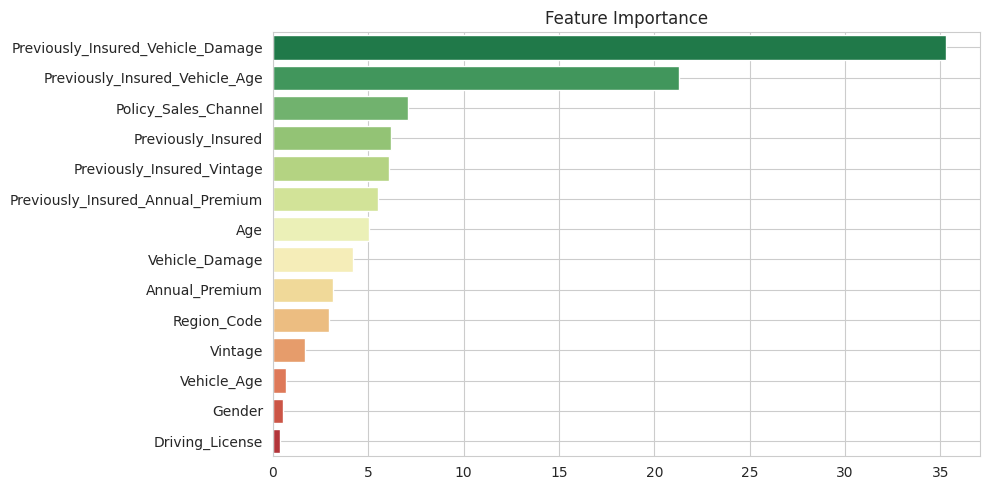

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))

fi = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
sns.barplot(
    y=fi.index, 
    x=fi.values, 
    orient='h', 
    palette=sns.color_palette('RdYlGn_r', len(X.columns))
)
plt.title('Feature Importance')
plt.grid(True)

plt.tight_layout()
plt.show()

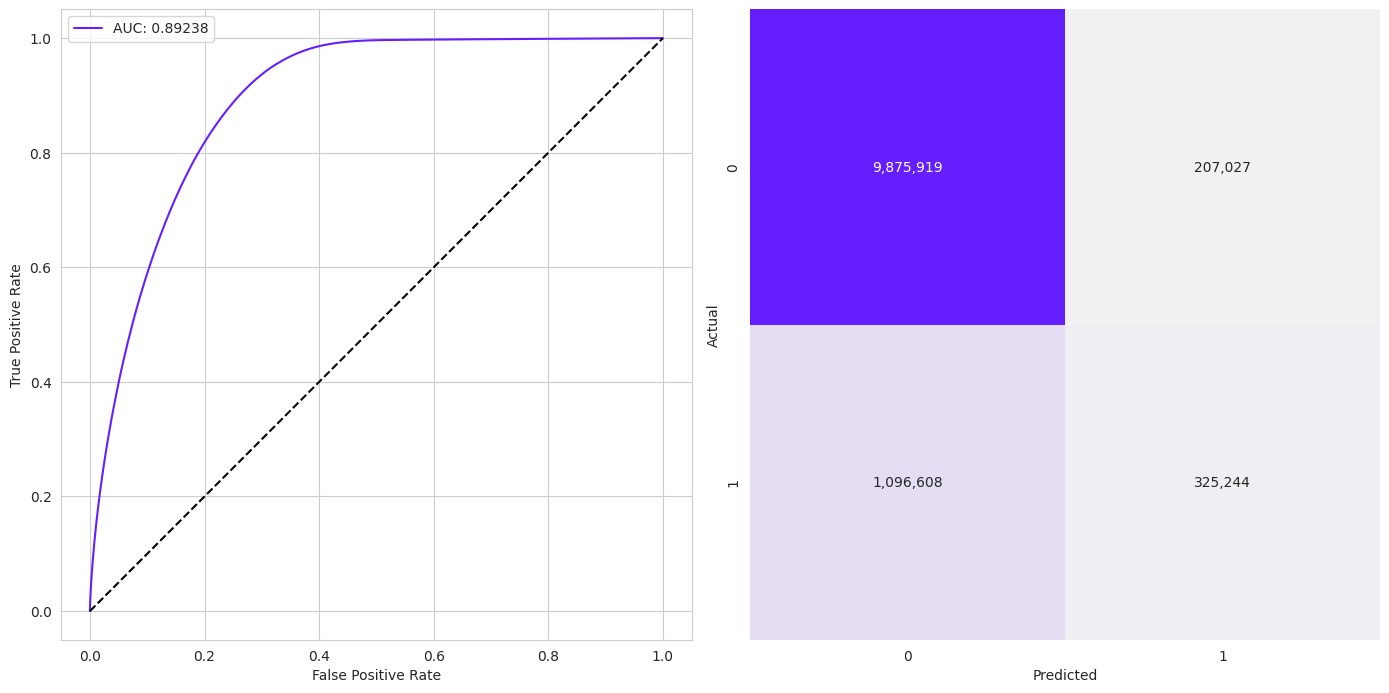

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, oof_pred_probs[:, 1])
axes[0].plot(fpr, tpr, label=f'AUC: {np.mean(scores):.5f}', color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = oof_pred_probs.argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt=',', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()